# Resampling signals on the 2-sphere

## Setup

In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn

from torch_harmonics import ResampleS2
from torch_harmonics.quadrature import _precompute_latitudes

import matplotlib.pyplot as plt
from torch_harmonics.plotting import plot_sphere

let's start by downloading our Mars topography again.

In [2]:
nlat = 257
nlon = 2*(nlat-1)
grid = "equiangular"

xq, wq = _precompute_latitudes(nlat, grid=grid)

In [3]:
os.makedirs("./data", exist_ok=True)
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze().float()

/home/bbonev/.zshenv:export:2: not valid in this context: :/usr/local/cuda-11.7/lib64
--2025-03-20 22:41:46--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... 

connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘./data/mola_topo.jpg’

./data/mola_topo.jp 100%[===================>]  53.90K   174KB/s    in 0.3s    

2025-03-20 22:41:47 (174 KB/s) - ‘./data/mola_topo.jpg’ saved [55192/55192]



let's plot it:

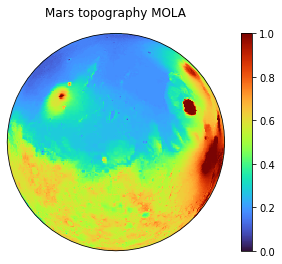

In [4]:
import matplotlib.pyplot as plt
from torch_harmonics.plotting import plot_sphere

plot_sphere(data, projection="orthographic", cmap="turbo", colorbar=True, title="Mars topography MOLA")
plt.show()

Let's bring the data to our desired input grid

In [5]:
grid_up = "equiangular"
grid_down = "legendre-gauss"

input_resample = ResampleS2(nlat, nlon, nlat, nlon, grid_in="equiangular", grid_out=grid_up)

data_res = input_resample(data)

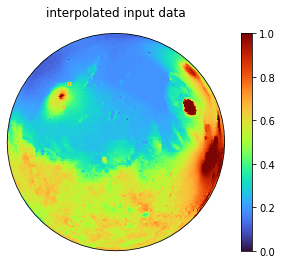

In [6]:
plot_sphere(data_res, projection="orthographic", cmap="turbo", colorbar=True, title="interpolated input data")

## Resampling

let us define down- and up-sampling layers:

In [7]:
scale_factor = 4

nlat_down = math.ceil(nlat / scale_factor)
nlon_down = math.ceil(nlon / scale_factor)

downsample = ResampleS2(nlat, nlon, nlat_down, nlon_down, grid_in=grid_up)
upsample = ResampleS2(nlat_down, nlon_down, nlat, nlon, grid_in=grid_down)

In [8]:
data_down = downsample(data)
data_up = upsample(data_down)

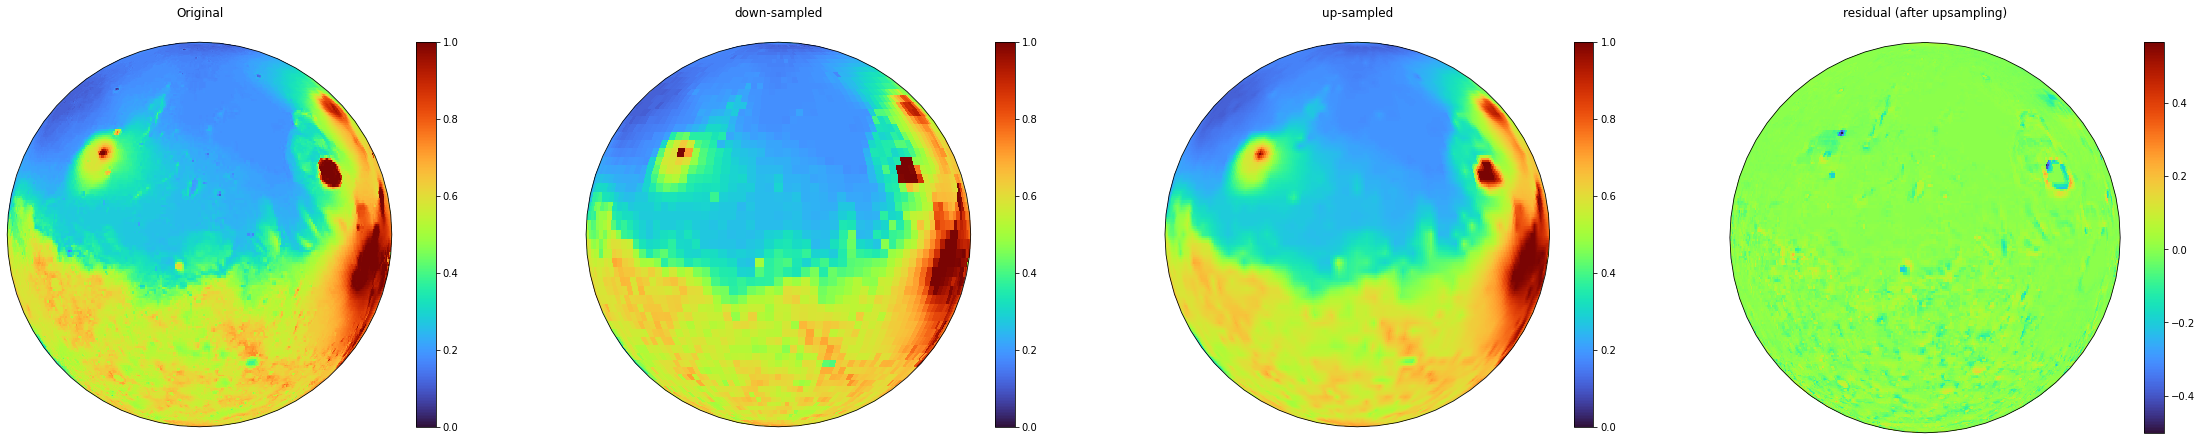

In [9]:
fig = plt.figure(layout='constrained', figsize=(32, 6))
subfigs = fig.subfigures(1, 4)

# spectral fitting
plot_sphere(data, fig=subfigs[0], projection="orthographic", cmap="turbo", colorbar=True, title="Original")
plot_sphere(data_down, fig=subfigs[1], projection="orthographic", cmap="turbo", colorbar=True, title="down-sampled")
plot_sphere(data_up, fig=subfigs[2], projection="orthographic", cmap="turbo", colorbar=True, title="up-sampled")
plot_sphere((data_up - data), fig=subfigs[3], projection="orthographic", cmap="turbo", colorbar=True, title="residual (after upsampling)")
plt.show()

In [10]:
print((data_up - data).abs().max())

tensor(0.5654)


## Upsampling error

In order to estimate the accuracy of up and down-sampling, let us compare it to idealized SHT upsampling

In [11]:
from torch_harmonics import RealSHT, InverseRealSHT

sht = RealSHT(nlat_down, nlon_down, grid=grid_down)
isht = InverseRealSHT(nlat, nlon, lmax=sht.lmax, mmax=sht.mmax, grid=grid_up)

In [12]:
data_up = upsample(data_down)
data_sht_up = isht(sht(data_down))

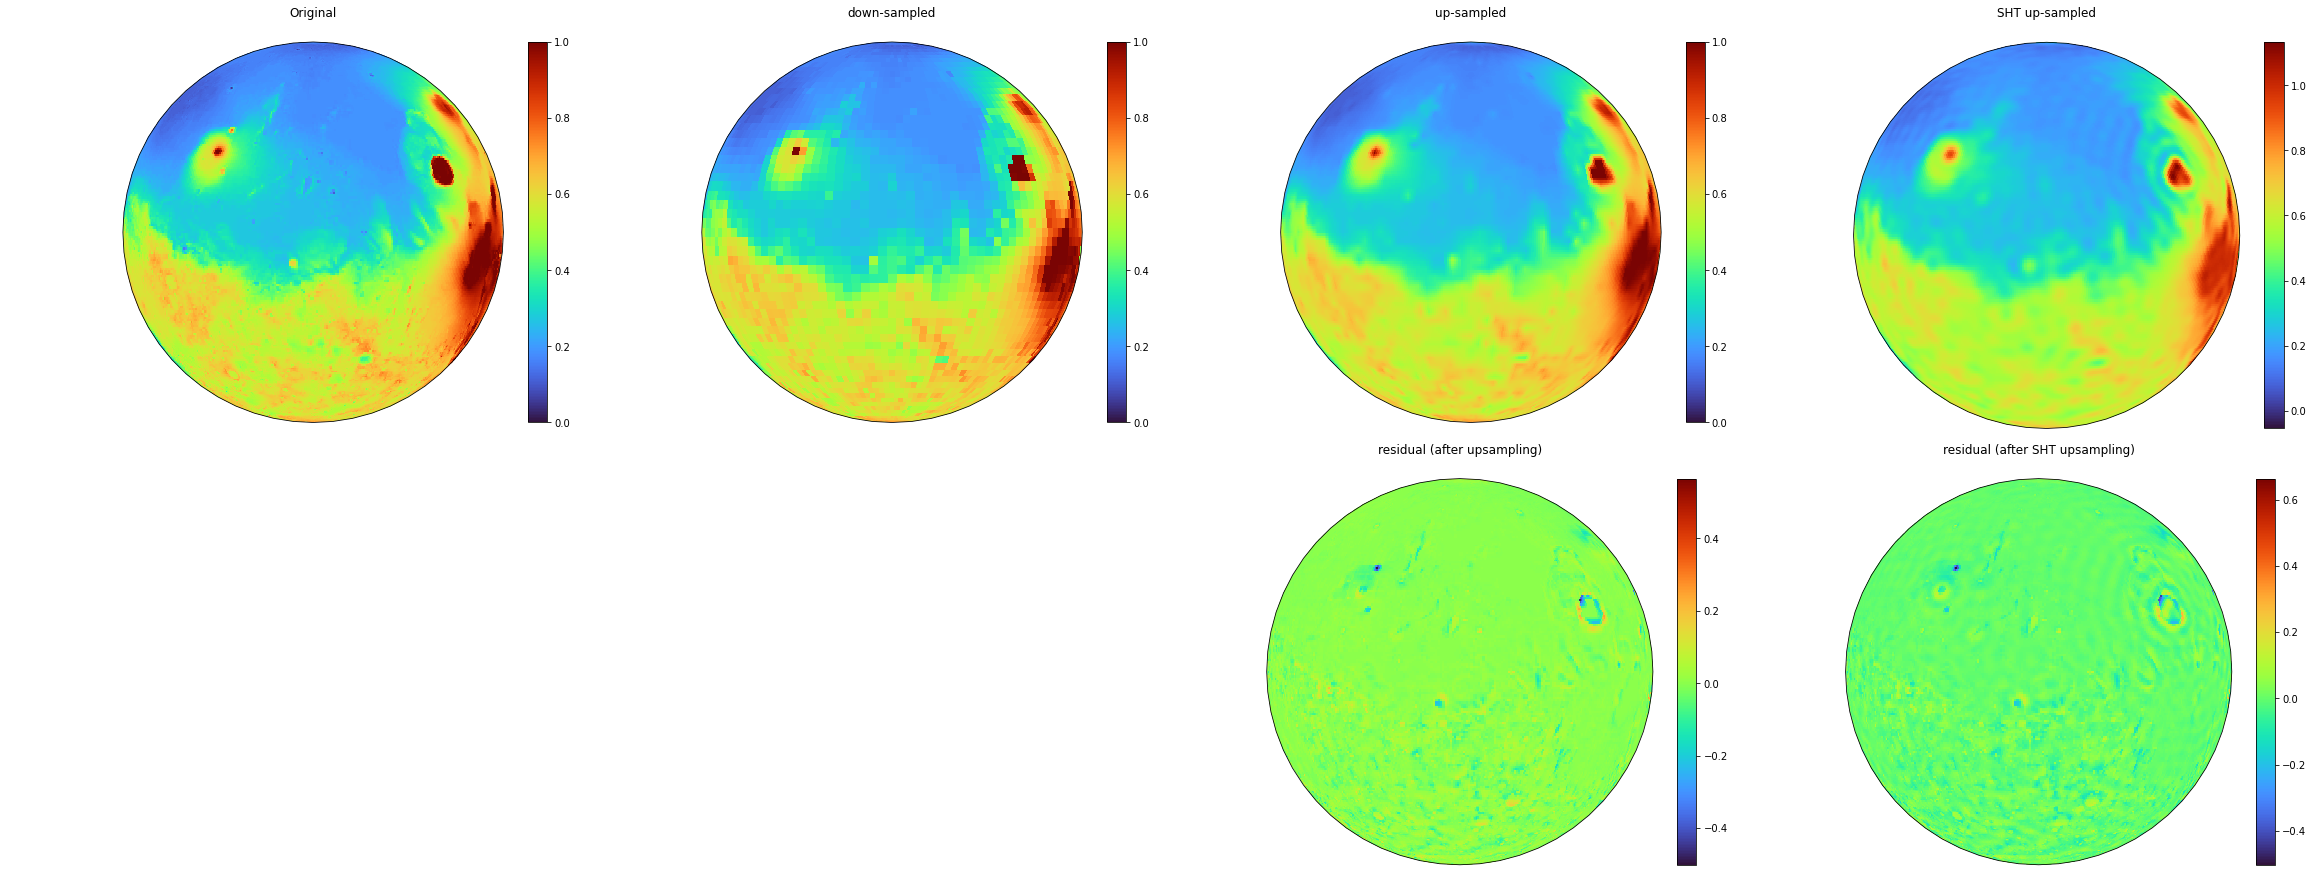

In [13]:
fig = plt.figure(layout='constrained', figsize=(32, 12))
subfigs = fig.subfigures(2, 4)

# spectral fitting
plot_sphere(data, fig=subfigs[0, 0], projection="orthographic", cmap="turbo", colorbar=True, title="Original")
plot_sphere(data_down, fig=subfigs[0, 1], projection="orthographic", cmap="turbo", colorbar=True, title="down-sampled")
plot_sphere(data_up, fig=subfigs[0, 2], projection="orthographic", cmap="turbo", colorbar=True, title="up-sampled")
plot_sphere(data_sht_up, fig=subfigs[0, 3], projection="orthographic", cmap="turbo", colorbar=True, title="SHT up-sampled")
plot_sphere((data_up - data), fig=subfigs[1, 2], projection="orthographic", cmap="turbo", colorbar=True, title="residual (after upsampling)")
plot_sphere((data_sht_up - data), fig=subfigs[1, 3], projection="orthographic", cmap="turbo", colorbar=True, title="residual (after SHT upsampling)")
plt.show()

We see that SHT upsampling suffers from ripples. This can be mitigated by choosing a grid which uses exact quadrature

In [14]:
print((data_up - data).abs().max())
print((data_sht_up - data).abs().max())

tensor(0.5654)
tensor(0.6636)
